In [11]:
%matplotlib inline
import xarray as xr
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 

import intake
import zarr

import gcsfs

In [17]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

For bias correction, we will be using 1995-2014. 

In [16]:
def convert_to_noleap_calendar(ds, target='noleap'):
    ds_noleap = convert_calendar(ds, target=target)
    return ds_noleap 

In [58]:
years = np.arange(1995, 2015)

In [59]:
variable = 'tmax'

In [60]:
filenames = [os.path.join('/gcs/impactlab-data/climate/source_data/ERA-5/day/%s/v1.1' %variable, 
                          '%s_daily_%s-%s.nc' %(variable, year, year)) for year in years]

In [61]:
# ! pip install xclim 

In [62]:
from xclim.core.calendar import convert_calendar

u = xr.open_dataset(filenames[1])
u_noleap = convert_calendar(u, target='noleap')

In [65]:
u.time

<xarray.DataArray 'time' (time: 366)>
array(['1996-01-01T00:00:00.000000000', '1996-01-02T00:00:00.000000000',
       '1996-01-03T00:00:00.000000000', ..., '1996-12-29T00:00:00.000000000',
       '1996-12-30T00:00:00.000000000', '1996-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31

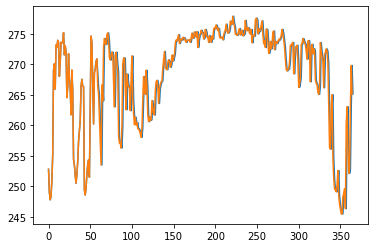

In [9]:
plt.plot(u['tmax'][:, 50, 100].values)
plt.plot(u_noleap['tmax'][:, 50, 100].values)

In [10]:
u_noleap.to_netcdf('test_calchange.nc')

try with a CMIP6 model 

In [93]:
import os
import intake 

# print("Searching catalog")
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
variable = 'tasmax'

cat = col.search(source_id='ACCESS-ESM1-5', institution_id='CSIRO', table_id='day', variable_id=variable, 
                 member_id='r1i1p1f1')

In [94]:
z_kwargs = {'consolidated': True, 'decode_times':False}

dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [95]:
# dset_dict

In [96]:
coords_to_drop = ['height', 'member_id']

model_historical = dset_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn'].isel(
    member_id=0).squeeze(drop=True).drop(coords_to_drop)
model_ssp370 = dset_dict['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn'].isel(
    member_id=0).squeeze(drop=True).drop(coords_to_drop)

In [100]:
if model_ssp370.time.dtype == 'int64':
    model_ssp370['time'] = xr.decode_cf(model_ssp370).time

In [102]:
convert_to_noleap_calendar(model_ssp370)

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 31390)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(582, 145, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP AerChemMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    creation_date:           2019-11-15T10:38:50Z
    data_specs_version:      01.00.30
    experiment:              gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:           ssp370
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    grid_label:              gn
    history:                 2019-11-15T10:38:50Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Commonwealth Scientific and Industrial Research ...
    institution_id:          CSIRO
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: ESM-ssp370; Local ID: SSP-370-05; Variable:...
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-ESM1-5
    parent_time_units:       days since 1850-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    source_id:               ACCESS-ESM1-5
    source_type:             AOGCM
    status:                  2020-06-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:             hdl:21.14100/701b06d0-3da1-47c4-a2ed-4635778cb16...
    variable_id:             tasmax
    variant_label:           r1i1p1f1
    version:                 v20191115
    netcdf_tracking_ids:     hdl:21.14100/701b06d0-3da1-47c4-a2ed-4635778cb16...
    version_id:              v20191115
    intake_esm_varname:      ['tasmax']
    intake_esm_dataset_key:  ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn

In [92]:
type(model_ssp370.time.values[0])

numpy.datetime64